In [ ]:
#Start by connecting gdrive into the google colab

from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import io
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics
import time
from google.colab import files

In [ ]:
pip install ipdb

     |████████████████████████████████| 791 kB 14.9 MB/s 
     |████████████████████████████████| 374 kB 31.6 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=29d3195a134728397fbcb966208f127527a1ce03dde42b8d4b531a493a5b0fde
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
!ls "/content/gdrive/MyDrive/Weed_Project/"

Average_Result.gsheet		model_weed_final_3.pt  train_subset1.csv
images				model_weed_final_4.pt  train_subset2.csv
labels.csv			model_weed_final.pt    train_subset3.csv
mobilenetv3-large-1cd25616.pth	model_weed.pt	       train_subset4.csv
mobilenetv3_small_67.4.pth.tar	test_subset0.csv       val_subset0.csv
model_weed_0.pt			test_subset1.csv       val_subset1.csv
model_weed_3.pt			test_subset2.csv       val_subset2.csv
model_weed_4.pt			test_subset3.csv       val_subset3.csv
model_weed_final_0_jit.pt	test_subset4.csv       val_subset4.csv
model_weed_final_0.pt		train_subset0.csv


In [ ]:

#df_train = []
#df_test = []
#df_val = []

df_train = pd.read_csv('/content/gdrive/MyDrive/Weed_Project/train_subset0.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/Weed_Project/test_subset0.csv')
df_val = pd.read_csv('/content/gdrive/MyDrive/Weed_Project/val_subset0.csv')


In [ ]:
class Weed_Dataset(Dataset):
    def __init__(self,root = '/content/gdrive/MyDrive/Weed_Project/images/' , data = None, transform=None):
        self.transform = transform
        self.data = data
        self.root = root
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):

        row = self.data.iloc[index].to_dict()
        img = row['Filename']
        img = Image.open(os.path.join(self.root,img))
        label = row['Label']
        if self.transform is not None:
            img = self.transform(img)
        return img, label

In [ ]:
batch_size = 32
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
train_transform = transforms.Compose(
    [
     transforms.Resize (240),
     transforms.RandomResizedCrop(224),
     transforms.RandomRotation(1.8),
     transforms.ToTensor(),
     normalize,
     ])

test_transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Resize(224),
     normalize,
     ])

weed_dataset_train = Weed_Dataset(root = '/content/gdrive/MyDrive/Weed_Project/images/', data = df_train, transform = train_transform)
weed_dataset_test = Weed_Dataset(root = '/content/gdrive/MyDrive/Weed_Project/images/', data = df_test, transform = test_transform) 
weed_dataset_val = Weed_Dataset(root = '/content/gdrive/MyDrive/Weed_Project/images/', data = df_val, transform = test_transform)
!ls
#import ipdb
#ipdb.set_trace()

train_loader = DataLoader(weed_dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(weed_dataset_val, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(weed_dataset_test, batch_size=batch_size, shuffle=False, num_workers=2)

#for im, label in weed_dataset_train:
  #print(im.shape)
  #print(label.shape)

gdrive	sample_data


In [ ]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=80, avg_pool_kernel_size = 7):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool1 = nn.AvgPool2d(7 , stride=2)
        #self.avgpool2 = nn.AvgPool2d(avg_pool_kernel_size, stride=1)
        #self.fc = nn.Linear(8192, num_classes)
        self.fc = nn.Linear(512 * block.expansion, 1000)

        self.final_feature_size = 512 * block.expansion

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool1(x)
        #print(x.shape)
        #x = self.avgpool2(x)
        x = x.view(x.size(0), -1)
        #x = self.fc(x)

        return x


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model

class WeedNet(nn.Module):
    def __init__(self, pretrained=True, n_class=9):
        super(WeedNet, self).__init__()
        self.backbone = resnet50()

        # building classifier
        #what is Sequential?
        # self.classifier = nn.Sequential(
        #     nn.Dropout(p=0.5),    # refer to paper section 6
        #     nn.Linear(self.backbone.final_feature_size, n_class),
        # )
        output_channel = 512
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.final_feature_size, n_class),
        )        
        #print(self)
        self._initialize_weights(pretrained)
        
    def _initialize_weights(self, pretrained=True):
        # random weight initialization of both backbone and classifier
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        # reinitialize backbone with imagenet pretrained model
        if pretrained:
            state_dict = torch.load('/content/gdrive/MyDrive/Weed_Project/resnet50-19c8e357.pth')
            self.backbone.load_state_dict(state_dict, strict=True)
            print("backbone successfully loaded!")                    

    def forward(self, x):

      # extracting feature
      x = self.backbone(x)
      #print('x.shape = ', x.shape, ' self.backbone.final_feature_size = ', self.backbone.final_feature_size)
      # class prediction score
      x = self.classifier(x)

      return x


In [ ]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [ ]:
!ls
model = WeedNet(pretrained=True, n_class=9)
model = model.to(device)  
#model.apply(init_weights)
#print(model)
criterion = nn.CrossEntropyLoss()

for p in model.backbone.parameters():
  p.requires_grad=False
for p in model.backbone.layer4.parameters():
  p.requires_grad=True
for p in model.classifier.parameters():
  p.requires_grad=True

optimizer = optim.Adam(filter(lambda p : p.requires_grad,model.parameters()), lr=0.00005)
n_epochs = 50
print_every = 30
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
start = time.time()
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    model.train()
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        #import ipdb
        #ipdb.set_trace()
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    y_true = []
    y_pred = []
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(val_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), '/content/gdrive/MyDrive/Weed_Project/resnet_model_weed_0.pt')
            print('Detected network improvement, saving current model')
print("Total time: ", time.time() - start, "seconds")
torch.save(model.state_dict(), '/content/gdrive/MyDrive/Weed_Project/resnet_model_weed_final_0.pt')

gdrive	sample_data
backbone successfully loaded!
Epoch 1



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/50], Step [0/329], Loss: 2.3247
Epoch [1/50], Step [20/329], Loss: 1.3879
Epoch [1/50], Step [40/329], Loss: 0.9182
Epoch [1/50], Step [60/329], Loss: 1.2875
Epoch [1/50], Step [80/329], Loss: 0.9934
Epoch [1/50], Step [100/329], Loss: 0.7738
Epoch [1/50], Step [120/329], Loss: 0.7304
Epoch [1/50], Step [140/329], Loss: 0.8456
Epoch [1/50], Step [160/329], Loss: 0.6254
Epoch [1/50], Step [180/329], Loss: 0.5399
Epoch [1/50], Step [200/329], Loss: 0.8287
Epoch [1/50], Step [220/329], Loss: 0.3384
Epoch [1/50], Step [240/329], Loss: 0.5209
Epoch [1/50], Step [260/329], Loss: 0.8898
Epoch [1/50], Step [280/329], Loss: 0.6453
Epoch [1/50], Step [300/329], Loss: 0.8900
Epoch [1/50], Step [320/329], Loss: 0.6498

train loss: 0.8495, train acc: 72.0408
validation loss: 0.5458, validation acc: 81.8338

Detected network improvement, saving current model
Epoch 2

Epoch [2/50], Step [0/329], Loss: 0.4320
Epoch [2/50], Step [20/329], Loss: 0.6884
Epoch [2/50], Step [40/329], Loss: 0.4358


In [ ]:
# Test the model on the test dataset
#import ipdb
from sklearn.metrics import confusion_matrix, classification_report
model = WeedNet(pretrained=False, n_class=9).to(device)  # #Please change the CNN structure (Net1() or Net2() or Net3())
state_dict = torch.load('/content/gdrive/MyDrive/Weed_Project/resnet_model_weed_final_0.pt')
model.load_state_dict(state_dict, strict=True)
print("Model successfully loaded!")

criterion = nn.CrossEntropyLoss()

#load trained model

val_acc = []
val_loss = []
valid_loss_min = np.Inf
batch_loss = 0
total_t=0
correct_t=0
y_true = []
y_pred = []
with torch.no_grad():
    model.eval()
    for batch_i, (data_t, target_t) in enumerate(test_loader):
        print('Batch id = ', batch_i)
        data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
        outputs_t = model(data_t)
        loss_t = criterion(outputs_t, target_t)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(pred_t==target_t).item()
        
        y_pred.extend(pred_t.tolist())
        y_true.extend(target_t.cpu().data.numpy().tolist())

        total_t += target_t.size(0)
    val_acc.append(100 * correct_t / total_t)
    val_loss.append(batch_loss/len(test_loader))
    network_learned = batch_loss < valid_loss_min
    print(f'Test loss: {np.mean(val_loss):.4f}, Test acc: {(100 * correct_t / total_t):.4f}\n')
 

Model successfully loaded!
Batch id =  0
Batch id =  1
Batch id =  2
Batch id =  3
Batch id =  4
Batch id =  5
Batch id =  6
Batch id =  7
Batch id =  8
Batch id =  9
Batch id =  10
Batch id =  11
Batch id =  12
Batch id =  13
Batch id =  14
Batch id =  15
Batch id =  16
Batch id =  17
Batch id =  18
Batch id =  19
Batch id =  20
Batch id =  21
Batch id =  22
Batch id =  23
Batch id =  24
Batch id =  25
Batch id =  26
Batch id =  27
Batch id =  28
Batch id =  29
Batch id =  30
Batch id =  31
Batch id =  32
Batch id =  33
Batch id =  34
Batch id =  35
Batch id =  36
Batch id =  37
Batch id =  38
Batch id =  39
Batch id =  40
Batch id =  41
Batch id =  42
Batch id =  43
Batch id =  44
Batch id =  45
Batch id =  46
Batch id =  47
Batch id =  48
Batch id =  49
Batch id =  50
Batch id =  51
Batch id =  52
Batch id =  53
Batch id =  54
Batch id =  55
Batch id =  56
Batch id =  57
Batch id =  58
Batch id =  59
Batch id =  60
Batch id =  61
Batch id =  62
Batch id =  63
Batch id =  64
Batch id

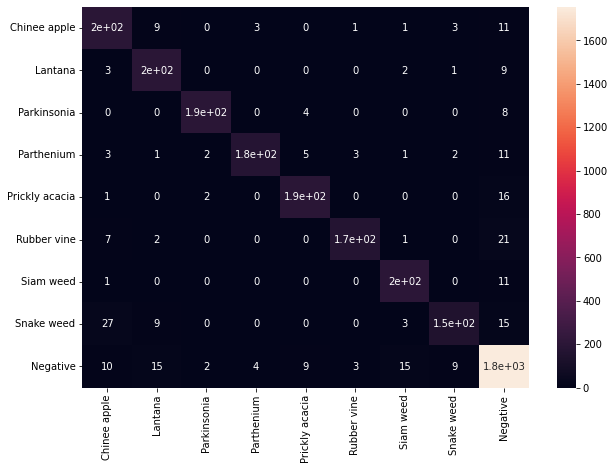

In [ ]:
 import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

classes = ["Chinee apple",
      "Lantana",
      "Parkinsonia",
      "Parthenium",
      "Prickly acacia",
      "Rubber vine",
      "Siam weed",
      "Snake weed",
      "Negative"]

 conf = confusion_matrix(y_true, y_pred)
 df_cm = pd.DataFrame(conf, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

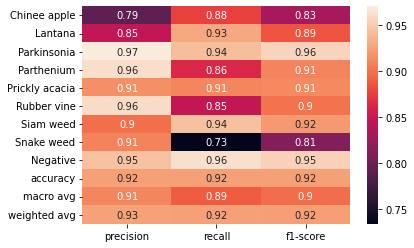

In [ ]:
report = classification_report(y_true, y_pred)
labels = np.arange(9)
clf_report = classification_report(y_true,
                                   y_pred,
                                   labels=labels,
                                   target_names=classes,
                                   output_dict=True)
hm_plot = sn.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
fig =  hm_plot.get_figure()
fig.savefig('/content/gdrive/MyDrive/Weed_Project/f1.png') 

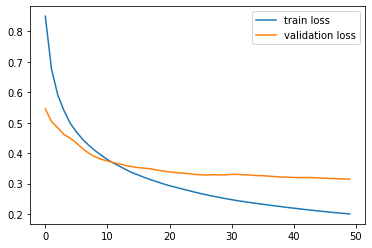

In [ ]:
res_file = '/content/gdrive/MyDrive/Weed_Project/results.txt'
train_losses = []
val_losses = []
train_accs = []
val_accs = []

with open(res_file) as fp:
    Lines = fp.readlines()
    for line in Lines:
        line = line.strip()

        if line.startswith('train loss:'):
          loss, acc = line.split(',')
          loss = float(loss.split(': ')[-1])
          acc = float(acc.split(': ')[-1])
          #print(line, loss, acc)
          train_losses.append(loss)
          train_accs.append(acc)

        elif line.startswith('validation loss:'):
          loss, acc = line.split(',')
          loss = float(loss.split(': ')[-1])
          acc = float(acc.split(': ')[-1])
          #print(line, loss, acc)
          val_losses.append(loss)
          val_accs.append(acc)          

line1, = plt.plot(train_losses, label='train loss')          
line2, = plt.plot(val_losses, label='validation loss')     
plt.legend(handles=[line1, line2], loc='upper right')
plt.savefig('/content/gdrive/MyDrive/Weed_Project/losses.png', dpi=300)
plt.show()

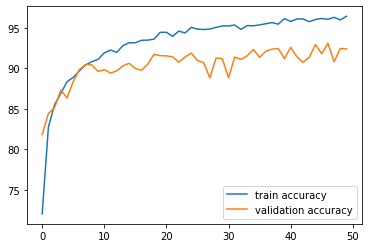

In [ ]:
line1, = plt.plot(train_accs, label='train accuracy')          
line2, = plt.plot(val_accs, label='validation accuracy')     
plt.legend(handles=[line1, line2], loc='lower right')
plt.savefig('/content/gdrive/MyDrive/Weed_Project/accuracies.png', dpi=300)
plt.show()

In [ ]:
import torch
import torchvision
from torch.utils.mobile_optimizer import optimize_for_mobile

model = WeedNet(pretrained=False, n_class=9)
state_dict = torch.load('/content/gdrive/MyDrive/Weed_Project/resnet_model_weed_final_0.pt')
model.load_state_dict(state_dict, strict=True)
model.eval()
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model, example)
optimized_traced_model = optimize_for_mobile(traced_script_module)
optimized_traced_model._save_for_lite_interpreter('/content/gdrive/MyDrive/Weed_Project/resnet_model_weed_final_0_jit.pt')

KeyboardInterrupt: ignored

In [ ]:
model = WeedNet(pretrained=False, n_class=9)
model

WeedNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         